In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
from IPython import display


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch


from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

import netCDF4 as nc
import glob

from functions.plot_metrics import plot_metrics
from functions.plot_metrics_one import plot_metrics_one
from functions import calc_metrics

/tmp/ipykernel_153009/2101664275.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-03-21 10:38:54.861678: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-21 10:38:54.896440: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 10:3

In [2]:
data_water=parse.parse('cloudrm2_water.dat')
data_clear=parse.parse('cloudrm2_clear.dat')
data_ice=parse.parse('cloudrm2_ice.dat')
data_mixed=parse.parse('cloudrm2_mixed.dat')

#Concatinate all datasets
#data_all=pd.concat([data_water,data_clear,data_ice,data_mixed,
#                    data_black_water,data_black_clear,data_black_ice,data_black_mixed])
data_all=pd.concat([data_water,data_clear,data_ice,data_mixed])


data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
data_all=data_all.reset_index()
data_all=data_all.drop(columns=('index'))

df=data_all.copy()

X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']
#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05',
              'Clear_B06','Clear_B07','Clear_B08', 'Clear_B09',
              'Clear_B10','Clear_B11','Clear_B12','Clear_B13']
#clear_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05',
#              'Clear_B06','Clear_B07','Clear_B08', 'Clear_B09',
#              'Clear_B10','Clear_B11','Clear_B12','Clear_B13']

#y_labels= ['OCloud_B02','OCloud_B03','OCloud_B04','OCloud_B05','OCloud_B06',
#           'OCloud_B07','OCloud_B08','OCloud_B09','OCloud_B10','OCloud_B11','OCloud_B12','OCloud_B13']

#df[y_labels]=df[X_labels].to_numpy()-df[clear_labels].to_numpy()

In [12]:
X=df[X_labels]
y=df[y_labels]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [13]:
X_train = X_train + np.random.randn(np.shape(X_train)[0],np.shape(X_train)[1]) * np.mean(X_train.to_numpy(),axis=0)*0.03
X_test = X_test + np.random.randn(np.shape(X_test)[0],np.shape(X_test)[1]) * np.mean(X_test.to_numpy(),axis=0)*0.03

In [14]:
#Normalise
X_mean=np.mean(X_train,axis=0).to_numpy()
X_std=np.std(X_train,axis=0).to_numpy()
X_train=(X_train-X_mean)/X_std

X_test=(X_test-X_mean)/X_std


In [15]:
print(np.mean(X_train,axis=0).to_numpy())
print(np.std(X_train,axis=0).to_numpy())
print(" ")
print(np.mean(X_test,axis=0).to_numpy())
print(np.std(X_test,axis=0).to_numpy())

[ 5.84288173e-16 -1.11199938e-16 -1.07069908e-16  9.09050613e-17
 -2.62323496e-16  8.50430837e-18 -1.66622272e-15  2.83750801e-16
  3.17967874e-17  3.30402372e-17  1.07869269e-16 -3.58957308e-16]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 
[-4.05222518e-03 -7.97024883e-05 -3.69865156e-03  2.71012697e-03
  2.37210614e-03  1.37069258e-03  1.70002047e-03  1.65819422e-03
 -6.06969378e-04 -5.15804368e-03  8.79375323e-03  5.43616030e-03]
[1.00159814 1.00125113 1.00276308 1.00335048 1.00851934 1.00775873
 1.00946119 1.00715295 1.00191094 0.99782198 1.002654   1.00003394]


In [16]:
params = {
    "n_estimators": 500,
    "max_depth": 10,
    "min_samples_split": 5,
    "learning_rate": 0.003,
    "loss": "squared_error",
}

In [17]:
def custom_learning_rate(iterations):
  """
  This function reduces the learning rate by 0.1 every 10 iterations.
  """
  return 0.1 * (1.0 - (iterations / 10))

In [18]:
import xgboost as xgb
# Define your training and target data (replace with your actual data)
# Your training features
# Your training target values

# Create the XGBoost regressor model
model = xgb.XGBRegressor(device='cuda',n_estimators=500,
                         max_depth=5,
                         learning_rates=custom_learning_rate,
                         loss='squared_error')

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on new data (replace with your new data)
X_new = X_test# Your new features
y_pred = model.predict(X_new)


/home/edgelab/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:40:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "loss" } are not used.

  warnings.warn(smsg, UserWarning)


In [19]:
mean_squared_error(y_test,y_pred)

0.009438828612646095

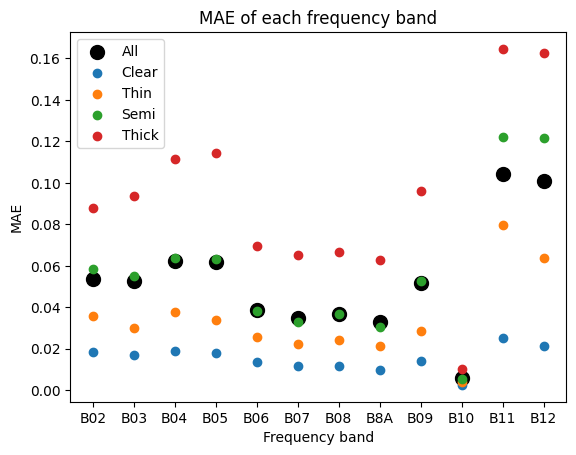

In [20]:
testindices=y_test.index
COTs=np.array(df['COT'].iloc[testindices])

#Divide into bins depending on COT
clear_true = y_test.to_numpy()[(COTs==0),:]
clear_pred = y_pred[(COTs==0),:]
thin_true = y_test.to_numpy()[(COTs>0) &  (COTs<3.6),:]
thin_pred = y_pred[(COTs>0) & (COTs<3.6),:]
semi_true = y_test.to_numpy()[(COTs>=3.6) & (COTs<23),:]
semi_pred = y_pred[(COTs>=3.6) & (COTs<23),:]
thick_true = y_test.to_numpy()[(COTs>=23),:]
thick_pred = y_pred[(COTs>=23),:]


#Find and print MAE of each band
MAE_col_tot = np.mean(np.abs(y_test.to_numpy()-y_pred),axis=0)
MAE_col_clear = np.mean(np.abs(clear_true-clear_pred),axis=0)
MAE_col_thin = np.mean(np.abs(thin_true-thin_pred),axis=0)
MAE_col_semi = np.mean(np.abs(semi_true-semi_pred),axis=0)
MAE_col_thick = np.mean(np.abs(thick_true-thick_pred),axis=0)

x=np.arange(np.size(MAE_col_tot))
plt.figure()
plt.scatter(x,MAE_col_tot,c='black',s=100)
plt.scatter(x,MAE_col_clear)
plt.scatter(x,MAE_col_thin)
plt.scatter(x,MAE_col_semi)
plt.scatter(x,MAE_col_thick)
plt.xticks(x, ['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
plt.title('MAE of each frequency band')
plt.xlabel('Frequency band')
plt.ylabel('MAE')
plt.legend(['All','Clear','Thin','Semi','Thick'])
plt.show()

In [ ]:
    ## Prediction v Ground Truth ##
    bins=np.linspace(0,1,100)
    
    freq_true=np.zeros(len(bins))
    freq_pred=np.zeros(len(bins))

    freq_true_zero=np.zeros(len(bins))
    freq_pred_zero=np.zeros(len(bins))

    freq_true_thin=np.zeros(len(bins))
    freq_pred_thin=np.zeros(len(bins))

    freq_true_med=np.zeros(len(bins))
    freq_pred_med=np.zeros(len(bins))

    y_tmp_zero=y_true[i][indices_zero[i]]
    y_tmp_thin=y_true[i][indices_thin[i]]
    y_tmp_med=y_true[i][indices_med[i]]

    y_tmp_pred_zero=y_pred[i][indices_zero[i]]
    y_tmp_pred_thin=y_pred[i][indices_thin[i]]
    y_tmp_pred_med=y_pred[i][indices_med[i]]

    for j,edge in enumerate(bins):
        if j!=0:
            indices=(y_true[i]>bins[j-1])&(y_true[i]<=edge)

            ind_z=(y_tmp_zero>bins[j-1])&(y_tmp_zero<=edge)
            ind_t=(y_tmp_thin>bins[j-1])&(y_tmp_thin<=edge)
            ind_m=(y_tmp_med>bins[j-1])&(y_tmp_med<=edge)

            mean_bin_true=np.mean(y_true[i][indices])
            mean_bin_pred=np.mean(y_pred[i][indices])

            mean_bin_true_zero=np.mean(y_tmp_zero[ind_z])
            mean_bin_pred_zero=np.mean(y_tmp_pred_zero[ind_z])

            mean_bin_true_thin=np.mean(y_tmp_thin[ind_t])
            mean_bin_pred_thin=np.mean(y_tmp_pred_thin[ind_t])

            mean_bin_true_med=np.mean(y_tmp_med[ind_m])
            mean_bin_pred_med=np.mean(y_tmp_pred_med[ind_m])
            
            freq_true[j]=mean_bin_true
            freq_pred[j]=mean_bin_pred

            freq_true_zero[j]=mean_bin_true_zero
            freq_pred_zero[j]=mean_bin_pred_zero

            freq_true_thin[j]=mean_bin_true_thin
            freq_pred_thin[j]=mean_bin_pred_thin

            freq_true_med[j]=mean_bin_true_med
            freq_pred_med[j]=mean_bin_pred_med

    axs[f_i].plot(freq_pred,freq_true,'.')
    axs[f_i].plot(freq_pred_zero,freq_true_zero,'.')
    axs[f_i].plot(freq_pred_thin,freq_true_thin,'.')
    axs[f_i].plot(freq_pred_med,freq_true_med,'.')
    #plt.plot(cloudy_sort,'.')
    line=np.linspace(0,1,100)
    axs[f_i].plot(line,line)
    axs[f_i].legend(['All predictions','Cloud free','Thin predictions','Medium predictions'])
    axs[f_i].set_xlabel("Prediction")
    axs[f_i].set_ylabel("Ground Truth")